In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from sklearn.neighbors import NearestNeighbors

In [23]:
# data_path = "../../data/planets/PS_2023.03.20_12.08.05.csv"
# data = pd.read_csv(data_path, skiprows=48)

data_path = "../../data/planets/PS_2023.05.07_09.42.30.csv"
data = pd.read_csv(data_path, skiprows=98)

In [24]:
len(data.columns)

92

In [25]:
data.columns

Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2

\newpage

# Scatter plots and histograms

## 1d

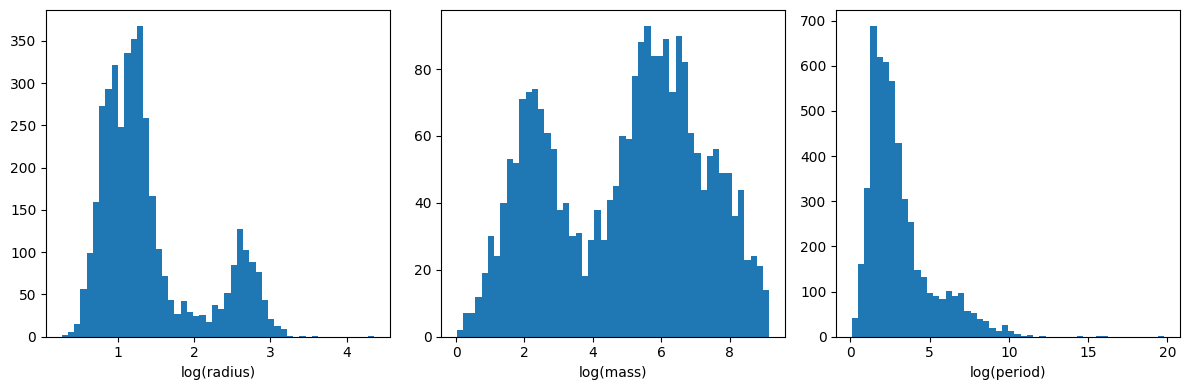

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(np.log(data["pl_rade"] + 1), bins=50)
axs[0].set_xlabel("log(radius)")

axs[1].hist(np.log(data["pl_bmasse"] + 1), bins=50)
axs[1].set_xlabel("log(mass)")

axs[2].hist(np.log(data["pl_orbper"] + 1), bins=50)
axs[2].set_xlabel("log(period)")

plt.tight_layout()
plt.show()

## 2d

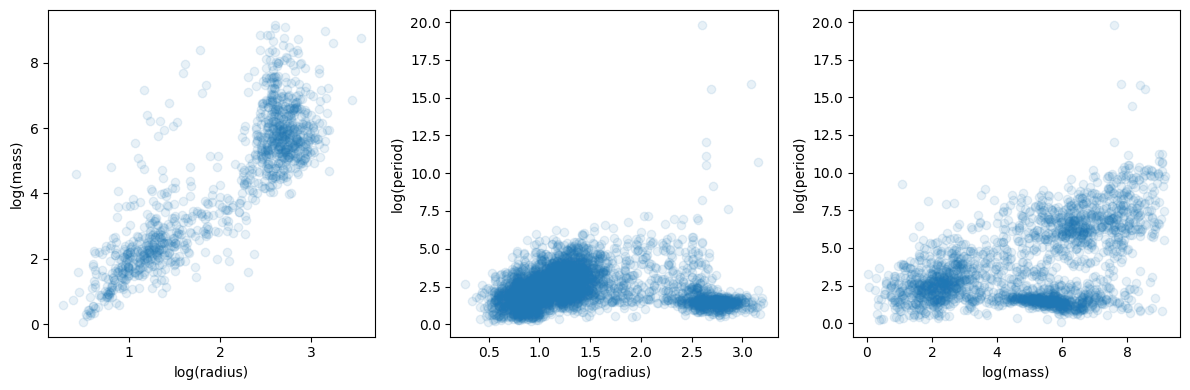

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(np.log(data["pl_rade"] + 1), np.log(data["pl_bmasse"] + 1), alpha=0.1)
axs[0].set_xlabel("log(radius)")
axs[0].set_ylabel("log(mass)")

axs[1].scatter(np.log(data["pl_rade"] + 1), np.log(data["pl_orbper"] + 1), alpha=0.1)
axs[1].set_xlabel("log(radius)")
axs[1].set_ylabel("log(period)")

axs[2].scatter(np.log(data["pl_bmasse"] + 1), np.log(data["pl_orbper"] + 1), alpha=0.1)
axs[2].set_xlabel("log(mass)")
axs[2].set_ylabel("log(period)")

plt.tight_layout()
plt.show()

\newpage

# Outliers detection

## 1d

\newpage

### Planet Radius

In [40]:
x_train = data[["pl_rade"]].dropna().to_numpy()
x_train = np.log(x_train + 1)
x_train.shape

(4030, 1)

#### Siatka po k (przy r=0.05)

Najlepsze k: 100.000, Wskaźnik: 0.954


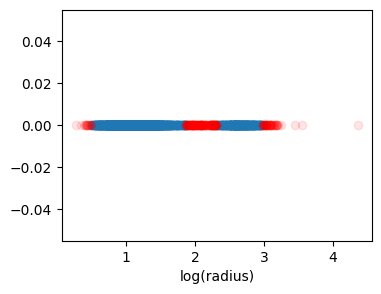

In [10]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
r = 0.05

metrics_list = []
k_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    k_list.append(k)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(radius)")
plt.show()

#### Siatka po r (przy k=10)

Najlepsze r: 0.010, Wskaźnik: 0.541


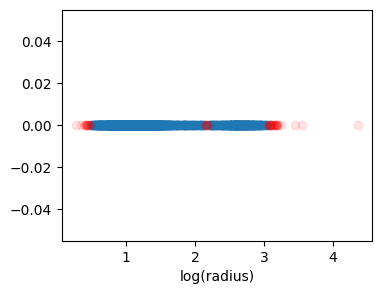

In [29]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(radius)")
plt.show()

#### Siatka po k oraz r

Najlepsze k: 50.000, r: 0.01, Wskaźnik: 0.493


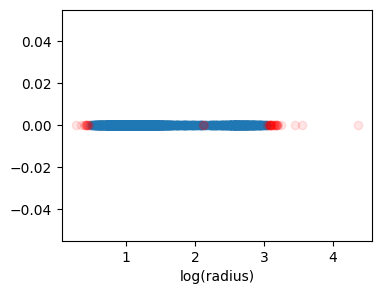

In [48]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
k_list = []
r_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    for r in np.arange(0.01, 0.41, 0.01):
        r = round(r, 3)

        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        k_list.append(k)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(radius)")
plt.show()

\newpage

### Planet Mass

In [49]:
x_train = data[["pl_bmasse"]].dropna().to_numpy()
x_train = np.log(x_train + 1)
x_train.shape

(2398, 1)

#### Siatka po k (przy r=0.05)

Najlepsze k: 200.000, Wskaźnik: 0.906


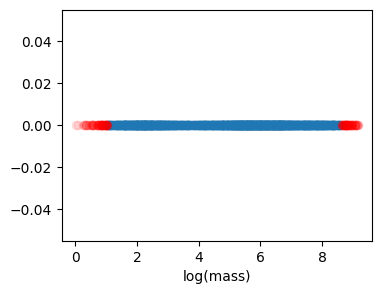

In [12]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
r = 0.05

metrics_list = []
k_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    k_list.append(k)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(mass)")
plt.show()

#### Siatka po r (przy k=10)

Najlepsze r: 0.010, Wskaźnik: 0.613


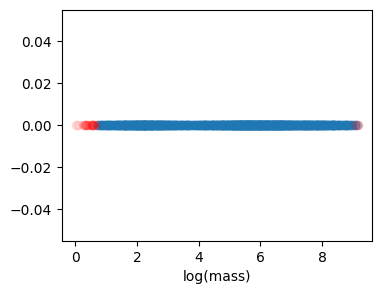

In [31]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(mass)")
plt.show()

#### Siatka po k oraz r

Najlepsze k: 50.000, r: 0.01, Wskaźnik: 0.570


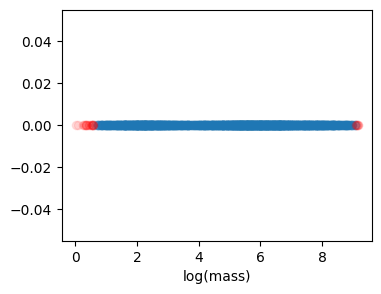

In [50]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
k_list = []
r_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    for r in np.arange(0.01, 0.41, 0.01):
        r = round(r, 3)

        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        k_list.append(k)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(mass)")
plt.show()

\newpage

### Orbital Period

In [51]:
x_train = data[["pl_orbper"]].dropna().to_numpy()
x_train = np.log(x_train + 1)
x_train.shape

(5111, 1)

#### Siatka po k (przy r=0.05)

Najlepsze k: 100.000, Wskaźnik: 0.837


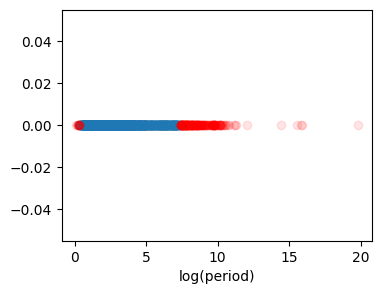

In [15]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
r = 0.05

metrics_list = []
k_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    k_list.append(k)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(period)")
plt.show()

#### Siatka po r (przy k=10)

Najlepsze r: 0.010, Wskaźnik: 0.560


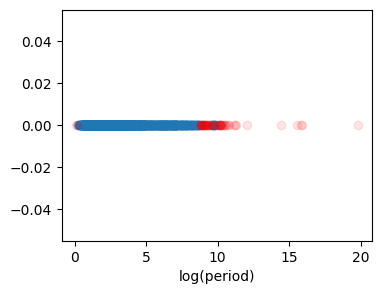

In [33]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(period)")
plt.show()

#### Siatka po k oraz r

Najlepsze k: 20.000, r: 0.01, Wskaźnik: 0.509


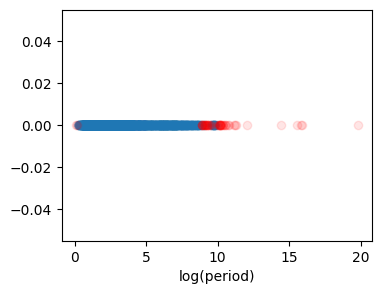

In [52]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
k_list = []
r_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    for r in np.arange(0.01, 0.41, 0.01):
        r = round(r, 3)

        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        k_list.append(k)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 0] * 0, alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 0] * 0, alpha=0.1, c="red")
plt.xlabel("log(period)")
plt.show()

\newpage

## 2d

### radius, mass

In [53]:
x_train = data[["pl_rade", "pl_bmasse"]].dropna().to_numpy()
x_train = np.log(x_train + 1)
x_train.shape

(1096, 2)

#### Siatka po k (przy r=0.05)

Najlepsze k: 5.000, Wskaźnik: 1.315


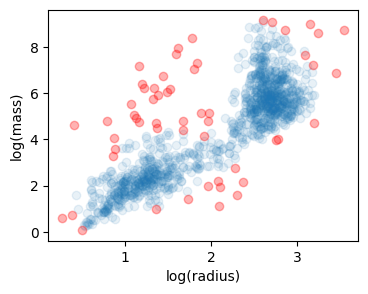

In [17]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
r = 0.05

metrics_list = []
k_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    k_list.append(k)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(radius)")
plt.ylabel("log(mass)")
plt.show()

#### Siatka po r (przy k=10)

Najlepsze r: 0.010, Wskaźnik: 1.479


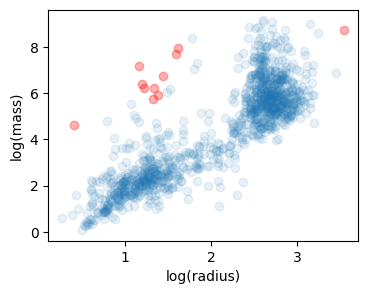

In [35]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(radius)")
plt.ylabel("log(mass)")
plt.show()

#### Siatka po k oraz r

Najlepsze k: 5.000, r: 0.01, Wskaźnik: 0.922


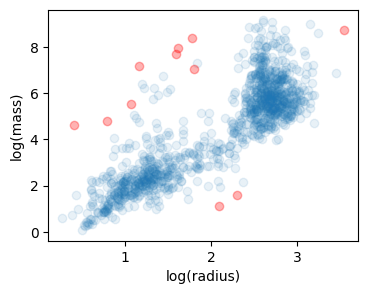

In [54]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
k_list = []
r_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    for r in np.arange(0.01, 0.41, 0.01):
        r = round(r, 3)

        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        k_list.append(k)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(radius)")
plt.ylabel("log(mass)")
plt.show()

\newpage

### radius, period

In [55]:
x_train = data[["pl_rade", "pl_orbper"]].dropna().to_numpy()
x_train = np.log(x_train + 1)
x_train.shape

(4014, 2)

#### Siatka po k (przy r=0.05)

Najlepsze k: 5.000, Wskaźnik: 1.212


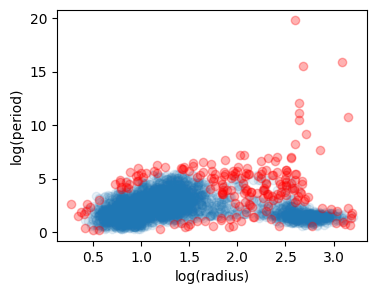

In [19]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
r = 0.05

metrics_list = []
k_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    k_list.append(k)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(radius)")
plt.ylabel("log(period)")
plt.show()

#### Siatka po r (przy k=10)

Najlepsze r: 0.010, Wskaźnik: 0.846


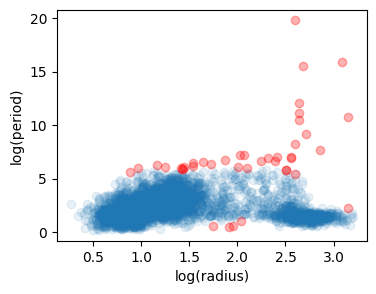

In [37]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(radius)")
plt.ylabel("log(period)")
plt.show()

#### Siatka po k oraz r

Najlepsze k: 5.000, r: 0.01, Wskaźnik: 0.727


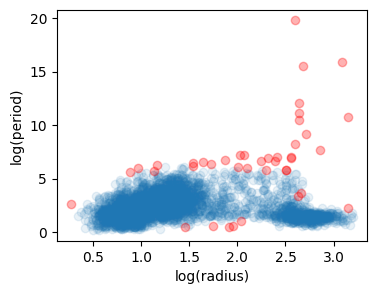

In [56]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
k_list = []
r_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    for r in np.arange(0.01, 0.41, 0.01):
        r = round(r, 3)

        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        k_list.append(k)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(radius)")
plt.ylabel("log(period)")
plt.show()

\newpage

### mass, period

In [57]:
x_train = data[["pl_bmasse", "pl_orbper"]].dropna().to_numpy()
x_train = np.log(x_train + 1)
x_train.shape

(2166, 2)

#### Siatka po k (przy r=0.05)

Najlepsze k: 5.000, Wskaźnik: 1.128


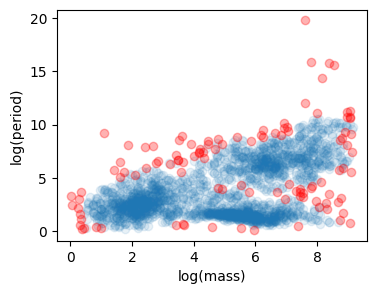

In [21]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
r = 0.05

metrics_list = []
k_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    k_list.append(k)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r)
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(mass)")
plt.ylabel("log(period)")
plt.show()

#### Siatka po r (przy k=10)

Najlepsze r: 0.010, Wskaźnik: 0.782


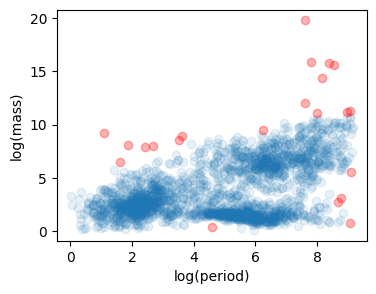

In [39]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
r_list = []
for r in np.arange(0.01, 0.51, 0.01):
    r = round(r, 3)

    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
    distances, indices = nbrs.kneighbors(x_train)
    dist_k = np.max(distances, axis=1)
    threshold = np.quantile(dist_k, 1 - r)
    labels_pred = np.where(dist_k >= threshold, 1 ,0)

    n_outliers = labels_pred.sum()
    if n_outliers == 0:
        continue

    inliers = labels_pred == 0
    outliers = labels_pred == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metrics = np.sum(scores_out) / np.sum(scores_in)

    metrics_list.append(metrics)
    r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze r: {r_list[idx]:.3f}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(period)")
plt.ylabel("log(mass)")
plt.show()

#### Siatka po k oraz r

Najlepsze k: 5.000, r: 0.01, Wskaźnik: 0.743


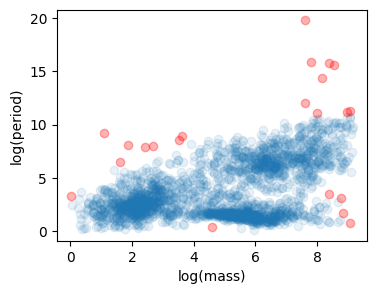

In [58]:
bandwidth = direct_plugin(x_train, stage=2)
kde = KDE().fit(x_train, bandwidth=bandwidth)
scores = kde.pdf(x_train)
k = 10

metrics_list = []
k_list = []
r_list = []
for k in np.array([5, 10, 20, 50, 100, 200, 500, 1000]):

    for r in np.arange(0.01, 0.41, 0.01):
        r = round(r, 3)

        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='brute').fit(x_train)
        distances, indices = nbrs.kneighbors(x_train)
        dist_k = np.max(distances, axis=1)
        threshold = np.quantile(dist_k, 1 - r)
        labels_pred = np.where(dist_k >= threshold, 1 ,0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        k_list.append(k)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepsze k: {k_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
nbrs = NearestNeighbors(n_neighbors=k_list[idx]+1, algorithm='brute').fit(x_train)
distances, indices = nbrs.kneighbors(x_train)
dist_k = np.max(distances, axis=1)
threshold = np.quantile(dist_k, 1 - r_list[idx])
labels_pred = np.where(dist_k >= threshold, 1 ,0)

plt.figure(figsize=(4, 3))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.3, c="red")
plt.xlabel("log(mass)")
plt.ylabel("log(period)")
plt.show()